In [1]:
import torch
from botorch.models import SingleTaskGP, MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import MultitaskGaussianLikelihood

from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel
from gpytorch.kernels import ProductKernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformer
from transformer import Transformer

In [2]:
# !pip install git+https://github.com/slaclab/lume-model
# from botorch.models.transforms.input import AffineInputTransform

In [3]:
#function to split on a pivot oppsed to a percentage
def split_on_point(x_values, y_values, pivot):
    #initialize arrays
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #for each x, if it is above the pivot, add the x and it's correlating y value
    for i, x in enumerate(x_values):
        if x > pivot:
            x_train.append(x)
            y_train.append(y_values[i])
        else:
            x_test.append(x)
            y_test.append(y_values[i])
            
    #convert all training gand testing arrays to tensors
    x_train = torch.tensor(x_train, dtype=torch.float32).reshape(-1,1)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.float32).reshape(-1,1)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [5]:
def multitask_model(x_sim, y_sim, x_train, y_train):
    # Define the kernels for simulation and experimental data
    sim_kernel = ScaleKernel(MaternKernel())
    linear_kernel = LinearKernel()

    x_sim_task = torch.cat([torch.zeros((x_sim.shape[0], 1)), x_sim], dim=1)
    x_train_task = torch.cat([torch.ones((x_train.shape[0], 1)), x_train], dim=1)

    # Create the multi-task GP model
    model = MultiTaskGP(
        torch.cat([x_sim_task, x_train_task], dim=0), 
        torch.cat([y_sim, y_train], dim=0),
        task_feature=0,  # Specify the task feature index
        covar_module= sim_kernel # ScaleKernel(RBFKernel())
    )

    # Fit the model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return model

In [6]:
def eval_mode(model, x_test, y_test):
    """
    Perform predictions using the provided model and likelihood on the given input data.

    Parameters:
    - model: The trained model.
    - likelihood: The likelihood function associated with the model.
    - x_data: The input data for which predictions are to be made.

    Returns:
    - mean_prediction: The mean predictions from the model.
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    inputs = torch.cat([x_test, y_test], dim=1)
    #model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        predictions = model.likelihood(model(inputs))
        mean_prediction = predictions.mean  # Mean prediction
        lower_bound, upper_bound = predictions.confidence_region()  # Confidence interval

    return mean_prediction, lower_bound, upper_bound

In [7]:
path_to_sim_data  = '/pscratch/sd/o/oshapova/ml_ldrd/data/simulation_data.csv'
path_to_exp_data = '/pscratch/sd/o/oshapova/ml_ldrd/data/experimental_data.csv'

In [8]:
df_sim = pd.read_csv(path_to_sim_data)
df_exp = pd.read_csv(path_to_exp_data)

In [9]:
x_sim = torch.tensor(df_sim['z_target (m)'].values, dtype=torch.float32).reshape(-1,1) #z_target_sim
y_sim = torch.tensor(df_sim['n_protons (1/sr)'].values, dtype=torch.float32).reshape(-1,1) #num_particles_sim

In [10]:
x_exp = torch.tensor(df_exp['z_target (m)'].values, dtype=torch.float32).reshape(-1,1) #z_target_sim
y_exp = torch.tensor(df_exp['n_protons (1/sr)'].values, dtype=torch.float32).reshape(-1,1) #num_particles_sim

Text(0, 0.5, 'n_protons (1/sr)')

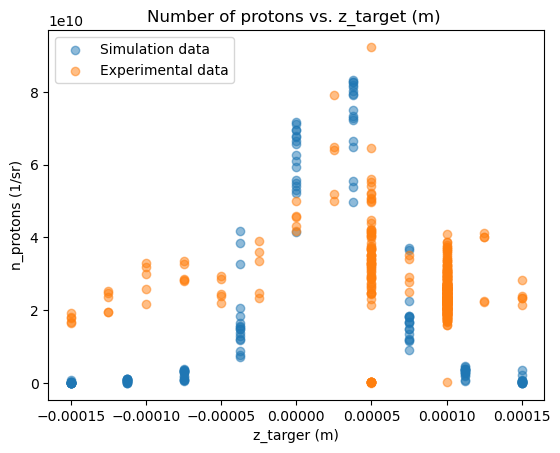

In [11]:
plt.scatter(x_sim, y_sim, label = 'Simulation data', alpha=0.5)
plt.scatter(x_exp, y_exp, label = 'Experimental data', alpha=0.5)
plt.legend()
plt.title("Number of protons vs. z_target (m) ")
plt.xlabel('z_targer (m)')
plt.ylabel('n_protons (1/sr)')

In [12]:
#Min/max values of y_sim

min_xsim_val = x_sim.min()
max_xsim_val = x_sim.max()

min_ysim_val = y_sim.min()
max_ysim_val = y_sim.max()
print(f"Minimum value of x_sim: {min_xsim_val}")
print(f"Maximum value of x_sim: {max_xsim_val}")

print(f"Minimum value of y_sim: {min_ysim_val}")
print(f"Maximum value of y_sim: {max_ysim_val}")

Minimum value of x_sim: -0.0001500000071246177
Maximum value of x_sim: 0.0001500000071246177
Minimum value of y_sim: 0.0
Maximum value of y_sim: 83335503872.0


In [13]:
# Normalization
#Setting Bounds
bound = max_xsim_val

x_bounds = torch.tensor([-bound, bound])
y_bounds =  torch.tensor([min_ysim_val, max_ysim_val])

#define transformers
x_transformer = transformer.Transformer(x_bounds.reshape(2,1), transform_type = 'normalize')
y_transformer = transformer.Transformer(y_bounds.reshape(2,1), transform_type = 'normalize')

y_sim_transformer = transformer.Transformer(y_bounds.reshape(2,1), transform_type = 'normalize')
y_exp_transformer = transformer.Transformer(y_bounds.reshape(2,1), transform_type = 'normalize')

#Full normalization process
def normalization(array, transformer):
    array = np.array(array).reshape(-1,1)
    array = torch.tensor(array)
    norm = transformer.forward(array)
    norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)
    return norm

In [29]:
# As Reva did:
#normalize
x_sim_normalized = normalization(x_sim, x_transformer)
y_sim_normalized = normalization(y_sim, y_sim_transformer)

exp_x_points = normalization(x_exp, x_transformer) 
exp_y_points = normalization(y_exp, y_exp_transformer)



spliting_z_val = 0.45
x_train_normalized, y_train_normalized, x_test_normalized, y_test_normalized = split_on_point(exp_x_points, exp_y_points, spliting_z_val) # set_1: 0.45; set_2: 0.6

/tmp/ipykernel_2243020/1622985998.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)


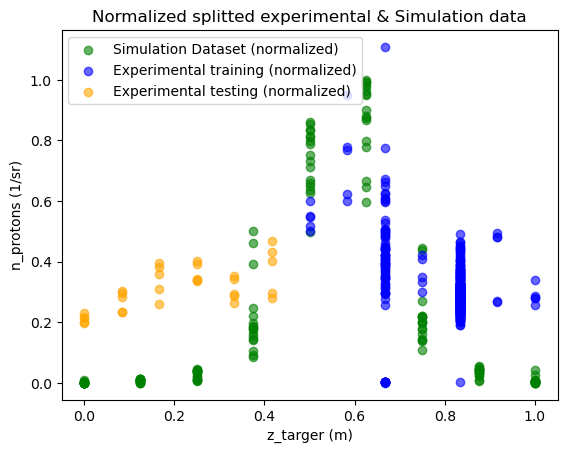

In [31]:
fig, ax = plt.subplots()

ax.scatter(x_sim_normalized, y_sim_normalized, label='Simulation Dataset (normalized)', color='green',alpha=0.6,)
ax.scatter(x_train_normalized, y_train_normalized, label='Experimental training (normalized)', color='blue',alpha=0.6,)
ax.scatter(x_test_normalized, y_test_normalized, label='Experimental testing (normalized)', color='orange',alpha=0.6,)

plt.title("Normalized splitted experimental & Simulation data")
plt.xlabel('z_targer (m)')
plt.ylabel('n_protons (1/sr)')
plt.savefig('/pscratch/sd/o/oshapova/ml_ldrd/plots/' + 'sim_exp_data__' + str(spliting_z_val)+ '.png')

plt.legend()


In [32]:
# Predict y_test
model = multitask_model(x_sim_normalized, y_sim_normalized, x_train_normalized, y_train_normalized)

predictions_on_test = model.posterior(x_test_normalized)
predictions_on_train = model.posterior(x_train_normalized)


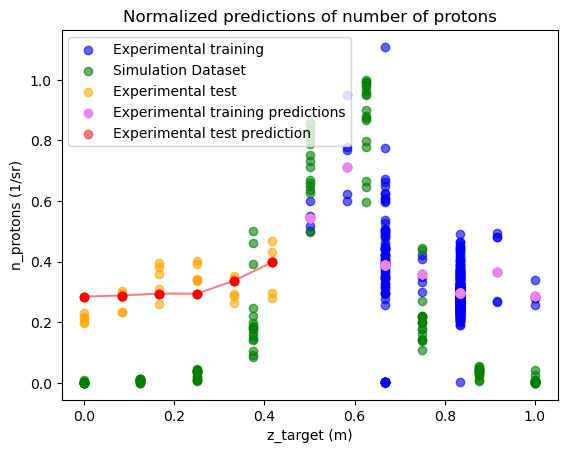

In [33]:
fig, ax = plt.subplots()

ax.scatter(x_train_normalized, y_train_normalized, label='Experimental training', alpha=0.6, color = 'blue')
ax.scatter(x_sim_normalized, y_sim_normalized, label='Simulation Dataset', alpha=0.6, color = 'green')

ax.scatter(x_test_normalized, y_test_normalized, label='Experimental test', alpha=0.6, color='orange')

ax.scatter(x_train_normalized, predictions_on_train.mean[:,1].detach().numpy(), label='Experimental training predictions', color='violet')

ax.plot(x_test_normalized, predictions_on_test.mean[:,1].detach().numpy(), alpha=0.5, color='red')
ax.scatter(x_test_normalized, predictions_on_test.mean[:,1].detach().numpy(), label='Experimental test prediction', alpha=0.5, color='red')


plt.title("Normalized predictions of number of protons")
plt.xlabel('z_target (m)')
plt.ylabel('n_protons (1/sr)')
plt.savefig('/pscratch/sd/o/oshapova/ml_ldrd/plots/' + 'n_protons_predictions_split_zval__' + str(spliting_z_val)+ '.png')
plt.legend()